# Panel Plots
We are creating this notebook in order to practice creating panel plots
for Savitzky smoothing method and see how different parameters affect our estimates.

In [1]:
import csv
import numpy as np
import pandas as pd
# import geopandas as gpd
from IPython.display import Image
# from shapely.geometry import Point, Polygon
from math import factorial
import datetime
import time
import scipy
import scipy.signal
import os, os.path

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.linear_model import LinearRegression
from patsy import cr

# from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sb


import sys
# start_time = time.time()

In [2]:
# search path for modules
# look @ https://stackoverflow.com/questions/67631/how-to-import-a-module-given-the-full-path

####################################################################################
###
###                      Local
###
####################################################################################

################
###
### Core path
###

sys.path.append('/Users/hn/Documents/00_GitHub/Ag/remote_sensing/python/')

################
###
### Directories
###
data_dir = "/Users/hn/Documents/01_research_data" + \
           "/remote_sensing/01_NDVI_TS/00_Eastern_WA_withYear/"

param_dir = "/Users/hn/Documents/00_GitHub/Ag/remote_sensing/parameters/"
####################################################################################
###
###                      Aeolus Core path
###
####################################################################################

# sys.path.append('/home/hnoorazar/remote_sensing_codes/')

####################################################################################
###
###                   Aeolus Directories
###
####################################################################################

# data_dir = "/data/hydro/users/Hossein/remote_sensing/01_NDVI_TS/00_Eastern_WA_EE/"
# param_dir = "/home/hnoorazar/remote_sensing_codes/parameters/"

####################################################################################
###
###                   Import remote cores
###
####################################################################################

import remote_sensing_core as rc
import remote_sensing_plot_core as rcp


In [3]:
####################################################################################
###
###      Parameters                   
###
####################################################################################

eleven_colors = ["gray", "lightcoral", "red", "peru",
                 "darkorange", "gold", "olive", "green",
                 "blue", "violet", "deepskyblue"]

irrigated_only = 0
SF_year = 2017
indeks = "EVI"
given_county = "Grant"

# we are creating panels where each panel
# consist of different parameters of Savitzky, 
# So, we do not need the following two

# Sav_win_size = int(sys.argv[1]) 
# sav_order = int(sys.argv[2])

# delt = float(sys.argv[1])
# indeks = sys.argv[2]
# irrigated_only = int(sys.argv[3])
# SF_year = int(sys.argv[4])


# Read the Data

In [4]:
f_name = "Eastern_WA_" + str(SF_year) + "_70cloud_selectors.csv"
a_df = pd.read_csv(data_dir + f_name, low_memory=False)

In [5]:
####################################################################################
###
###                   process data
###
####################################################################################

##################################################################
##################################################################
####
####  plots has to be exact. So, we need 
#### to filter out NASS, and filter by last survey date
####
##################################################################
##################################################################

a_df = a_df[a_df['county']== given_county] # Filter Grant
a_df.head(2)

a_df = rc.filter_out_NASS(a_df) # Toss NASS
a_df.head(2)

a_df = rc.filter_by_lastSurvey(a_df, year = SF_year) # filter by last survey date
a_df['SF_year'] = SF_year
a_df.head(2)

########################
########################

if irrigated_only == True:
    a_df = rc.filter_out_nonIrrigated(a_df)
    output_Irr = "irrigated_only"
else:
    output_Irr = "non_irrigated_only"
    a_df = rc.filter_out_Irrigated(a_df)
    
a_df.head(2)

######################

# The following columns do not exist in the old data
#
if not('DataSrc' in a_df.columns):
    print ("Data source is being set to NA")
    a_df['DataSrc'] = "NA"


if not('CovrCrp' in a_df.columns):
    print ("CovrCrp is being set to NA")
    a_df['CovrCrp'] = "NA"

if (indeks == "EVI"):
    a_df = rc.initial_clean_EVI(a_df)
else:
    a_df = rc.initial_clean_NDVI(a_df)

a_df.head(2)
an_EE_TS = a_df.copy()

CovrCrp is being set to NA


In [6]:
### List of unique polygons
polygon_list = an_EE_TS['ID'].unique()
print(len(polygon_list))

336


In [14]:
counter = 0
# for loop here
a_poly = polygon_list[counter]
if (counter%1000 == 0):
    print (counter)

curr_field = an_EE_TS[an_EE_TS['ID']==a_poly].copy()
curr_field.sort_values(by=['image_year', 'doy'], inplace=True)

ID = curr_field['ID'].unique()[0]

################################################################

plant = curr_field['CropTyp'].unique()[0]
# Take care of names, replace "/" and "," and " " by "_"
plant = plant.replace("/", "_")
plant = plant.replace(",", "_")
plant = plant.replace(" ", "_")
plant = plant.replace("__", "_")

county = curr_field['county'].unique()[0]


0


In [15]:


################################################################
plant = curr_field['CropTyp'].unique()[0]

# Take care of names, replace "/" and "," and " " by "_"
plant = plant.replace("/", "_")
plant = plant.replace(",", "_")
plant = plant.replace(" ", "_")
plant = plant.replace("__", "_")

county = curr_field['county'].unique()[0]
ID = curr_field['ID'].unique()[0]

In [16]:
print (curr_field.shape)
curr_field = curr_field[curr_field.image_year.isin([2016, 2017])]
print (curr_field.image_year.unique())
print (curr_field.shape)

(62, 27)
[2016 2017]
(50, 27)


# Start Inside of the Function

In [17]:
crr_fld = curr_field.copy()
idx = "EVI"
deltA = 0.1

In [22]:
print (crr_fld.shape)
crr_fld.head(2)

(50, 27)


,ID,Acres,BSI,county,CropGrp,CropTyp,DataSrc,doy,EVI,ExctAcr,...,PSRI,RtCrpTy,Shap_Ar,Shp_Lng,system_start_time,TRS,image_year,B8,SF_year,CovrCrp
240550,113035_WSDA_SF_2017,5.0,0.019722,Grant,Other,fallow,wsda,275.0,0.213343,4.697693,...,0.090664,Timothy,19010.890707,622.089116,1.475434e+12,T15R24E32,2016,0.273118,2017,NA
1461259,113035_WSDA_SF_2017,5.0,0.012637,Grant,Other,fallow,wsda,295.0,0.233983,4.697693,...,-0.002979,Timothy,19010.890707,622.089116,1.477162e+12,T15R24E32,2016,0.195637,2017,NA


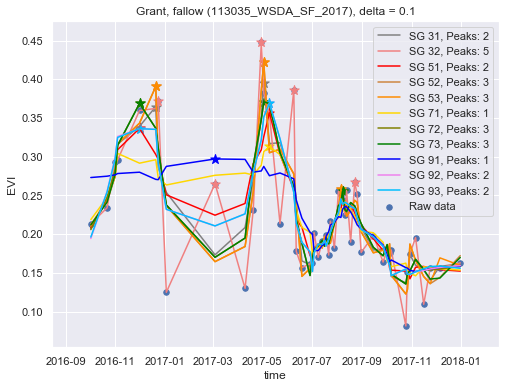

In [46]:
if (not("human_system_start_time" in list(crr_fld.columns))):
    crr_fld = rc.add_human_start_time(crr_fld)

eleven_colors = ["gray", "lightcoral", "red", "peru",
                 "darkorange", "gold", "olive", "green",
                 "blue", "violet", "deepskyblue"]

plant = crr_fld['CropTyp'].unique()[0]
# Take care of names, replace "/" and "," and " " by "_"
plant = plant.replace("/", "_")
plant = plant.replace(",", "_")
plant = plant.replace(" ", "_")
plant = plant.replace("__", "_")

county = crr_fld['county'].unique()[0]
ID = crr_fld['ID'].unique()[0]

y = crr_fld[idx]

#############################################
###
###             Smoothen
###
#############################################
# differences are minor, but lets keep using Pythons function
# my_savitzky_pred = rc.savitzky_golay(y, window_size=Sav_win_size, order=sav_order)

SG_pred_31 = scipy.signal.savgol_filter(y, window_length= 3, polyorder=1)
SG_pred_32 = scipy.signal.savgol_filter(y, window_length= 3, polyorder=2)

SG_pred_51 = scipy.signal.savgol_filter(y, window_length= 5, polyorder=1)
SG_pred_52 = scipy.signal.savgol_filter(y, window_length= 5, polyorder=2)
SG_pred_53 = scipy.signal.savgol_filter(y, window_length= 5, polyorder=3)

SG_pred_71 = scipy.signal.savgol_filter(y, window_length= 7, polyorder=1)
SG_pred_72 = scipy.signal.savgol_filter(y, window_length= 7, polyorder=2)
SG_pred_73 = scipy.signal.savgol_filter(y, window_length= 7, polyorder=3)

SG_pred_91 = scipy.signal.savgol_filter(y, window_length= 9, polyorder=1)
SG_pred_92 = scipy.signal.savgol_filter(y, window_length= 9, polyorder=2)
SG_pred_93 = scipy.signal.savgol_filter(y, window_length= 9, polyorder=3)


#############################################
###
###             find peaks
###
#############################################
# X = crr_fld['doy']
X = rc.extract_XValues_of_RegularizedTS_2Yrs(crr_fld, SF_yr = SF_year)

d = {'DoY': X, 'Date': pd.to_datetime(crr_fld.human_system_start_time.values).values}
date_df = pd.DataFrame(data=d)
"""
Jul 1.
This function is written since Kirti said
we do not need to have parts of the next year. i.e. 
if we are looking at what is going on in a field in 2017,
we only need data since Aug. 2016 till the end of 2017.
We do not need anything in 2018.
"""

SG_max_min_31 = rc.my_peakdetect(y_axis=SG_pred_31, x_axis=X, delta=deltA);
SG_max_31 =  SG_max_min_31[0]; SG_min_31 =  SG_max_min_31[1];
SG_max_31 = rc.separate_x_and_y(m_list = SG_max_31);
SG_min_31 = rc.separate_x_and_y(m_list = SG_min_31);
SG_max_DoYs_series_31 = pd.Series(SG_max_31[0]);
SG_max_series_31 = pd.Series(SG_max_31[1]);
SG_min_DoYs_series_31 = pd.Series(SG_min_31[0]);
SG_min_series_31 = pd.Series(SG_min_31[1]);


SG_max_min_32 = rc.my_peakdetect(y_axis=SG_pred_32, x_axis=X, delta=deltA);
SG_max_32 =  SG_max_min_32[0]; SG_min_32 =  SG_max_min_32[1];
SG_max_32 = rc.separate_x_and_y(m_list = SG_max_32);
SG_min_32 = rc.separate_x_and_y(m_list = SG_min_32);
SG_max_DoYs_series_32 = pd.Series(SG_max_32[0]);
SG_max_series_32 = pd.Series(SG_max_32[1]);
SG_min_DoYs_series_32 = pd.Series(SG_min_32[0]);
SG_min_series_32 = pd.Series(SG_min_32[1]);

############
############ window 5
############

SG_max_min_51 = rc.my_peakdetect(y_axis=SG_pred_51, x_axis=X, delta=deltA);
SG_max_51 =  SG_max_min_51[0]; SG_min_51 =  SG_max_min_51[1];
SG_max_51 = rc.separate_x_and_y(m_list = SG_max_51);
SG_min_51 = rc.separate_x_and_y(m_list = SG_min_51);
SG_max_DoYs_series_51 = pd.Series(SG_max_51[0]);
SG_max_series_51 = pd.Series(SG_max_51[1]);
SG_min_DoYs_series_51 = pd.Series(SG_min_51[0]);
SG_min_series_51 = pd.Series(SG_min_51[1]);

SG_max_min_52 = rc.my_peakdetect(y_axis=SG_pred_52, x_axis=X, delta=deltA);
SG_max_52 =  SG_max_min_52[0]; SG_min_52 =  SG_max_min_52[1];
SG_max_52 = rc.separate_x_and_y(m_list = SG_max_52);
SG_min_52 = rc.separate_x_and_y(m_list = SG_min_52);
SG_max_DoYs_series_52 = pd.Series(SG_max_52[0]);
SG_max_series_52 = pd.Series(SG_max_52[1]);
SG_min_DoYs_series_52 = pd.Series(SG_min_52[0]);
SG_min_series_52 = pd.Series(SG_min_52[1]);

SG_max_min_53 = rc.my_peakdetect(y_axis=SG_pred_53, x_axis=X, delta=deltA);
SG_max_53 =  SG_max_min_53[0]; SG_min_53 =  SG_max_min_53[1];
SG_max_53 = rc.separate_x_and_y(m_list = SG_max_53);
SG_min_53 = rc.separate_x_and_y(m_list = SG_min_53);
SG_max_DoYs_series_53 = pd.Series(SG_max_53[0]);
SG_max_series_53 = pd.Series(SG_max_53[1]);
SG_min_DoYs_series_53 = pd.Series(SG_min_53[0]);
SG_min_series_53 = pd.Series(SG_min_53[1]);

############
############ window 7
############

SG_max_min_71 = rc.my_peakdetect(y_axis=SG_pred_71, x_axis=X, delta=deltA);
SG_max_71 =  SG_max_min_71[0]; SG_min_71 =  SG_max_min_71[1];
SG_max_71 = rc.separate_x_and_y(m_list = SG_max_71);
SG_min_71 = rc.separate_x_and_y(m_list = SG_min_71);
SG_max_DoYs_series_71 = pd.Series(SG_max_71[0]);
SG_max_series_71 = pd.Series(SG_max_71[1]);
SG_min_DoYs_series_71 = pd.Series(SG_min_71[0]);
SG_min_series_71 = pd.Series(SG_min_71[1]);

SG_max_min_72 = rc.my_peakdetect(y_axis=SG_pred_72, x_axis=X, delta=deltA);
SG_max_72 =  SG_max_min_72[0]; SG_min_72 =  SG_max_min_72[1];
SG_max_72 = rc.separate_x_and_y(m_list = SG_max_72);
SG_min_72 = rc.separate_x_and_y(m_list = SG_min_72);
SG_max_DoYs_series_72 = pd.Series(SG_max_72[0]);
SG_max_series_72 = pd.Series(SG_max_72[1]);
SG_min_DoYs_series_72 = pd.Series(SG_min_72[0]);
SG_min_series_72 = pd.Series(SG_min_72[1]);

SG_max_min_73 = rc.my_peakdetect(y_axis=SG_pred_73, x_axis=X, delta=deltA);
SG_max_73 =  SG_max_min_73[0]; SG_min_73 =  SG_max_min_73[1];
SG_max_73 = rc.separate_x_and_y(m_list = SG_max_73);
SG_min_73 = rc.separate_x_and_y(m_list = SG_min_73);
SG_max_DoYs_series_73 = pd.Series(SG_max_73[0]);
SG_max_series_73 = pd.Series(SG_max_73[1]);
SG_min_DoYs_series_73 = pd.Series(SG_min_73[0]);
SG_min_series_73 = pd.Series(SG_min_73[1]);

############
############ window 9
############

SG_max_min_91 = rc.my_peakdetect(y_axis=SG_pred_91, x_axis=X, delta=deltA);
SG_max_91 =  SG_max_min_91[0]; SG_min_91 =  SG_max_min_91[1];
SG_max_91 = rc.separate_x_and_y(m_list = SG_max_91);
SG_min_91 = rc.separate_x_and_y(m_list = SG_min_91);
SG_max_DoYs_series_91 = pd.Series(SG_max_91[0]);
SG_max_series_91 = pd.Series(SG_max_91[1]);
SG_min_DoYs_series_91 = pd.Series(SG_min_91[0]);
SG_min_series_91 = pd.Series(SG_min_91[1]);

SG_max_min_92 = rc.my_peakdetect(y_axis=SG_pred_92, x_axis=X, delta=deltA);
SG_max_92 =  SG_max_min_92[0]; SG_min_92 =  SG_max_min_92[1];
SG_max_92 = rc.separate_x_and_y(m_list = SG_max_92);
SG_min_92 = rc.separate_x_and_y(m_list = SG_min_92);
SG_max_DoYs_series_92 = pd.Series(SG_max_92[0]);
SG_max_series_92 = pd.Series(SG_max_92[1]);
SG_min_DoYs_series_92 = pd.Series(SG_min_92[0]);
SG_min_series_92 = pd.Series(SG_min_92[1]);

SG_max_min_93 = rc.my_peakdetect(y_axis=SG_pred_93, x_axis=X, delta=deltA);
SG_max_93 =  SG_max_min_93[0]; SG_min_93 =  SG_max_min_93[1];
SG_max_93 = rc.separate_x_and_y(m_list = SG_max_93);
SG_min_93 = rc.separate_x_and_y(m_list = SG_min_93);
SG_max_DoYs_series_93 = pd.Series(SG_max_93[0]);
SG_max_series_93 = pd.Series(SG_max_93[1]);
SG_min_DoYs_series_93 = pd.Series(SG_min_93[0]);
SG_min_series_93 = pd.Series(SG_min_93[1]);

########################################################################################################
########################################################################################################

plotting_dic = { "SG 31" : [SG_pred_31, SG_max_DoYs_series_31, SG_max_series_31],
                 "SG 32" : [SG_pred_32, SG_max_DoYs_series_32, SG_max_series_32],

                 "SG 51" : [SG_pred_51, SG_max_DoYs_series_51, SG_max_series_51],
                 "SG 52" : [SG_pred_52, SG_max_DoYs_series_52, SG_max_series_52],
                 "SG 53" : [SG_pred_53, SG_max_DoYs_series_53, SG_max_series_53],

                 "SG 71" : [SG_pred_71, SG_max_DoYs_series_71, SG_max_series_71],
                 "SG 72" : [SG_pred_72, SG_max_DoYs_series_72, SG_max_series_72],
                 "SG 73" : [SG_pred_73, SG_max_DoYs_series_73, SG_max_series_73],

                 "SG 91" : [SG_pred_91, SG_max_DoYs_series_91, SG_max_series_91],
                 "SG 92" : [SG_pred_92, SG_max_DoYs_series_92, SG_max_series_92],
                 "SG 93" : [SG_pred_93, SG_max_DoYs_series_93, SG_max_series_93]
                 }

#############################################
###
###             plot
###
#############################################
#
#   We have to change this part to make a perfect plot
#        
plot_title = county + ", " + plant + " (" + ID + "), delta = " + str(deltA)

fig, ax = plt.subplots(figsize=(8,6));
ax.scatter(date_df.Date, y, label="Raw data", s=30);

for co, ite in enumerate(plotting_dic):
    lbl = ite + ", Peaks: " + str(len(plotting_dic[ite][2]))
    # ax.plot(X, plotting_dic[ite][0], label = lbl, c = eleven_colors[co])
    ax.plot(date_df.Date, plotting_dic[ite][0], label = lbl, c = eleven_colors[co])

    date_df_specific = date_df[date_df.DoY.isin(plotting_dic[ite][1])]
             # plotting_dic[ite][1]
    ax.scatter(date_df_specific.Date, plotting_dic[ite][2], s=100, marker='*', c = eleven_colors[co]);

ax.set_title(plot_title);
ax.set(xlabel='time', ylabel=idx)
ax.legend(loc="best");


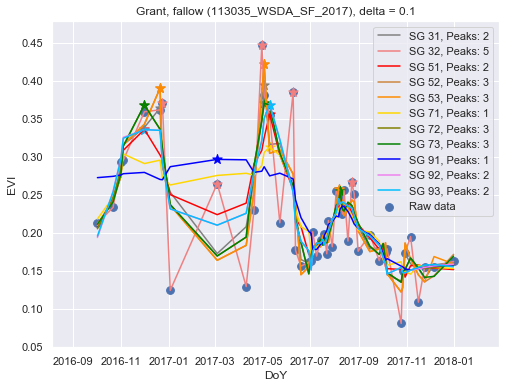

In [60]:
A = subplots_savitzky_2_yrs(crr_fld = crr_fld, idx = "EVI", deltA=0.1, SFYr = SF_year)

In [49]:
SF_year

2017

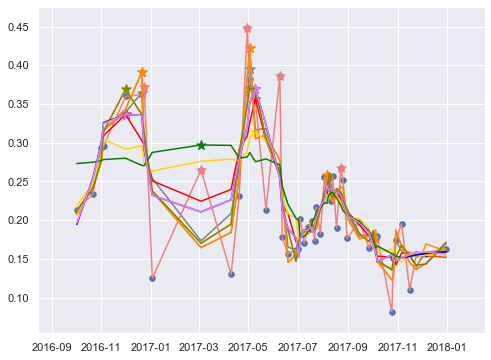

In [39]:
#############################################
###
###             plot
###
#############################################
#
#   We have to change this part to make a perfect plot
#        
plot_title = county + ", " + plant + " (" + ID + "), delta = " + str(deltA)

fig, ax = plt.subplots(figsize=(8,6));
ax.scatter(date_df.Date, y, label="Raw data", s=30);

co = 0; ite = "SG 31"
lbl = ite + ", Peaks: " + str(len(plotting_dic[ite][2]))
ax.plot(date_df.Date, plotting_dic[ite][0], label = lbl, c = eleven_colors[co])

date_df_specific = date_df[date_df.DoY.isin(plotting_dic[ite][1])]
         # plotting_dic[ite][1]
ax.scatter(date_df_specific.Date, plotting_dic[ite][2], s=100, marker='*', c = eleven_colors[co]);


co = 1; ite = "SG 32"
lbl = ite + ", Peaks: " + str(len(plotting_dic[ite][2]))
ax.plot(date_df.Date, plotting_dic[ite][0], label = lbl, c = eleven_colors[co])

date_df_specific = date_df[date_df.DoY.isin(plotting_dic[ite][1])]
         # plotting_dic[ite][1]
ax.scatter(date_df_specific.Date, plotting_dic[ite][2], s=100, marker='*', c = eleven_colors[co]);

co = 2; ite = "SG 51"
lbl = ite + ", Peaks: " + str(len(plotting_dic[ite][2]))
ax.plot(date_df.Date, plotting_dic[ite][0], label = lbl, c = eleven_colors[co])

date_df_specific = date_df[date_df.DoY.isin(plotting_dic[ite][1])]
         # plotting_dic[ite][1]
ax.scatter(date_df_specific.Date, plotting_dic[ite][2], s=100, marker='*', c = eleven_colors[co]);

co = 3; ite = "SG 52"
lbl = ite + ", Peaks: " + str(len(plotting_dic[ite][2]))
ax.plot(date_df.Date, plotting_dic[ite][0], label = lbl, c = eleven_colors[co])

date_df_specific = date_df[date_df.DoY.isin(plotting_dic[ite][1])]
         # plotting_dic[ite][1]
ax.scatter(date_df_specific.Date, plotting_dic[ite][2], s=100, marker='*', c = eleven_colors[co]);

co = 4; ite = "SG 53"
lbl = ite + ", Peaks: " + str(len(plotting_dic[ite][2]))
ax.plot(date_df.Date, plotting_dic[ite][0], label = lbl, c = eleven_colors[co])

date_df_specific = date_df[date_df.DoY.isin(plotting_dic[ite][1])]
         # plotting_dic[ite][1]
ax.scatter(date_df_specific.Date, plotting_dic[ite][2], s=100, marker='*', c = eleven_colors[co]);


co = 5; ite = "SG 71"
lbl = ite + ", Peaks: " + str(len(plotting_dic[ite][2]))
ax.plot(date_df.Date, plotting_dic[ite][0], label = lbl, c = eleven_colors[co])

date_df_specific = date_df[date_df.DoY.isin(plotting_dic[ite][1])]
         # plotting_dic[ite][1]
ax.scatter(date_df_specific.Date, plotting_dic[ite][2], s=100, marker='*', c = eleven_colors[co]);



co = 5; ite = "SG 72"
lbl = ite + ", Peaks: " + str(len(plotting_dic[ite][2]))
ax.plot(date_df.Date, plotting_dic[ite][0], label = lbl, c = eleven_colors[co])

date_df_specific = date_df[date_df.DoY.isin(plotting_dic[ite][1])]
         # plotting_dic[ite][1]
ax.scatter(date_df_specific.Date, plotting_dic[ite][2], s=100, marker='*', c = eleven_colors[co]);


co = 6; ite = "SG 73"
lbl = ite + ", Peaks: " + str(len(plotting_dic[ite][2]))
ax.plot(date_df.Date, plotting_dic[ite][0], label = lbl, c = eleven_colors[co])

date_df_specific = date_df[date_df.DoY.isin(plotting_dic[ite][1])]
         # plotting_dic[ite][1]
ax.scatter(date_df_specific.Date, plotting_dic[ite][2], s=100, marker='*', c = eleven_colors[co]);


co = 7; ite = "SG 91"
lbl = ite + ", Peaks: " + str(len(plotting_dic[ite][2]))
ax.plot(date_df.Date, plotting_dic[ite][0], label = lbl, c = eleven_colors[co])

date_df_specific = date_df[date_df.DoY.isin(plotting_dic[ite][1])]
         # plotting_dic[ite][1]
ax.scatter(date_df_specific.Date, plotting_dic[ite][2], s=100, marker='*', c = eleven_colors[co]);


co = 8; ite = "SG 92"
lbl = ite + ", Peaks: " + str(len(plotting_dic[ite][2]))
ax.plot(date_df.Date, plotting_dic[ite][0], label = lbl, c = eleven_colors[co])

date_df_specific = date_df[date_df.DoY.isin(plotting_dic[ite][1])]
         # plotting_dic[ite][1]
ax.scatter(date_df_specific.Date, plotting_dic[ite][2], s=100, marker='*', c = eleven_colors[co]);



co = 9; ite = "SG 93"
lbl = ite + ", Peaks: " + str(len(plotting_dic[ite][2]))
ax.plot(date_df.Date, plotting_dic[ite][0], label = lbl, c = eleven_colors[co])

date_df_specific = date_df[date_df.DoY.isin(plotting_dic[ite][1])]
         # plotting_dic[ite][1]
ax.scatter(date_df_specific.Date, plotting_dic[ite][2], s=100, marker='*', c = eleven_colors[co]);


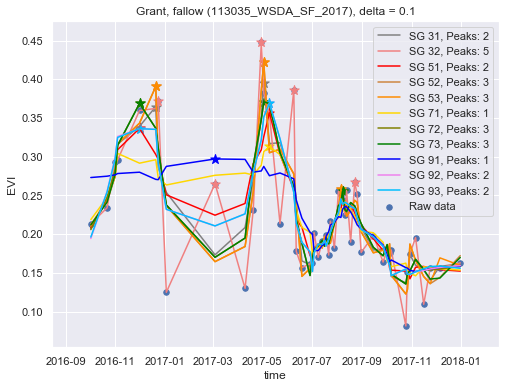

In [ ]:
eleven_colors = ["gray", "lightcoral", "red", "peru",
                 "darkorange", "gold", "olive", "green",
                 "blue", "violet", "deepskyblue"]

plant = current_field['CropTyp'].unique()[0]
# Take care of names, replace "/" and "," and " " by "_"
plant = plant.replace("/", "_")
plant = plant.replace(",", "_")
plant = plant.replace(" ", "_")
plant = plant.replace("__", "_")

county = current_field['county'].unique()[0]
ID = current_field['ID'].unique()[0]

y = current_field[idx]

In [ ]:
X = rc.extract_XValues_of_RegularizedTS_2Yrs(current_field, SF_yr=2017)

d = {'DoY': X, 'Date': pd.to_datetime(current_field.human_system_start_time.values).values}
date_df = pd.DataFrame(data=d)

In [ ]:
SG_max_min_31 = rc.my_peakdetect(y_axis=SG_pred_31, x_axis=X, delta=deltA);
SG_max_31 =  SG_max_min_31[0]; SG_min_31 =  SG_max_min_31[1];
SG_max_31 = rc.separate_x_and_y(m_list = SG_max_31);
SG_min_31 = rc.separate_x_and_y(m_list = SG_min_31);
SG_max_DoYs_series_31 = pd.Series(SG_max_31[0]);
SG_max_series_31 = pd.Series(SG_max_31[1]);
SG_min_DoYs_series_31 = pd.Series(SG_min_31[0]);
SG_min_series_31 = pd.Series(SG_min_31[1]);

In [ ]:
plot_title = county + ", " + plant + " (" + ID + "), delta = " + str(deltA)
# sb.set();

fig, ax = plt.subplots(figsize=(8,6));
ax.scatter(date_df.Date, y, label="Raw data", s=30);
co = 0
ite = "SG 31"

lbl = ite + ", Peaks: " + str(len(plotting_dic[ite][2]))
ax.plot(date_df.Date, plotting_dic[ite][0], label = lbl, c = eleven_colors[co])

date_df_specific = date_df[date_df.DoY.isin(plotting_dic[ite][1])]
ax.scatter(date_df_specific.Date, plotting_dic[ite][2], s=100, marker='*', c = eleven_colors[co]);

In [ ]:
plotting_dic[ite][1].values

In [ ]:
np.where(X == 355)

In [ ]:
plotting_dic[ite][1]

In [ ]:
fig_name = "/Users/hn/Desktop/" + county + "_" + plant + "_" + str(SF_year) + "_" + str(counter) + '.png'